# MLab Bird Classification Project, Fall 2024

In this project, we build a deep learning model to classify images of various bird species. Using a dataset of labeled bird images, we preprocess the data, design a convolutional neural network (CNN), and train the model to identify birds from a set of classes. We utilize PyTorch for model construction and training, with data augmentation to enhance the model's robustness. The goal of this project is to explore various techniques in deep learning, model evaluation, and optimization, and to understand how deep neural networks can be applied to image classification problems.

## Setup

This section sets up the environment by mounting Google Drive, verifying the project path, and ensuring that the necessary files are accessible. The project folder is located in Google Drive, and we mount it for data access.

In [ ]:
from google.colab import drive
import sys
import os

# Step 1: Re-mount Google Drive if needed
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Step 2: Set the path and verify
FOLDERNAME = 'MLab Project'
PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)

# Verify the path exists
if os.path.exists(PATH):
    print(f"Path exists: {PATH}")
    os.chdir(PATH)  # Change the working directory using os module
else:
    print(f"Path does not exist: {PATH}")

# Append the path to sys.path if needed
sys.path.append(PATH)


Mounted at /content/drive
Path exists: /content/drive/My Drive/MLab Project


Here, we import the necessary libraries for deep learning (PyTorch), image processing (PIL, torchvision), and data manipulation (Pandas). We also import plotting tools for visualizing training progress and data.

In [ ]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Data processing
import pandas as pd

# Data transformations
import torchvision

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm

# Other
import time
from datetime import date
import PIL
import utils

Call .to(device=device), where device was set to "cuda" at the top of the notebook, wherever you have an input tensor or instantiate a model.

In [ ]:
# Set PyTorch to use the GPU
device = torch.device('cuda')

## Dataset


This class loads a small dataset of bird images from a CSV file. The CSV contains file paths, labels, and classes. It defines methods to retrieve images and labels, the total number of samples, and class names.

In [ ]:
class BirdDatasetSmall(torch.utils.data.Dataset):
  def __init__(self, csv_path):
    self.images = []
    self.labels = []
    self.classes = []

    self.classes = ['GREAT XENOPS', 'KIWI', 'OSPREY']

    df = pd.read_csv(csv_path)
    for index, row in df.iterrows():
      image = Image.open(row['filepath'])
      self.images.append(image)
      self.labels.append(row['label'])


    assert len(self.images) == len(self.labels)

  def __len__(self):
    """Returns the number of examples in the dataset"""
    return len(self.images)

  def num_classes(self):
    """Returns the number of classes in the dataset"""
    return len(self.classes)

  def get_class(self, label):
    """Returns the name of the bird corresponding to the given label value"""
    return self.classes[label]

  def get_image(self, idx):
    """Returns the image of the idx'th example in the dataset"""
    return self.images[idx]

  def get_label(self, idx):
    """Returns the label of the idx'th example in the dataset"""
    return self.labels[idx]

  def __getitem__(self, idx):
    """Returns a tuple of the image and label of the idx'th example in the dataset"""
    image = self.get_image(idx)
    label = self.get_label(idx)
    return image, label

  def display(self, idx):
    """Displays the image at a given index"""
    display(self.get_image(idx))

#### Testing BirdDatasetSmall

This code tests the BirdDatasetSmall class to ensure that it loads the dataset correctly, verifying the length of the dataset and checking that the labels are properly assigned.

In [ ]:
def test_case(message, value, expected_value):
  print(message)
  if value == expected_value:
    print("  PASSED")
  else:
    print(f"  EXPECTED: {expected_value}")
    print(f"  GOT: {value}")

small_dataset = BirdDatasetSmall("small_data.csv")

test_case("Length of the dataset", len(small_dataset), 45)
test_case("Label of idx=17", small_dataset.get_label(17), 1)

Length of the dataset
  PASSED
Label of idx=17
  PASSED


Next, we'll display some images from the dataset. The output of running the cell should match the following image:

![](https://drive.google.com/uc?export=view&id=1mqvn-KXh8mWV6HcxulAnNqDhIPPWCq6f)

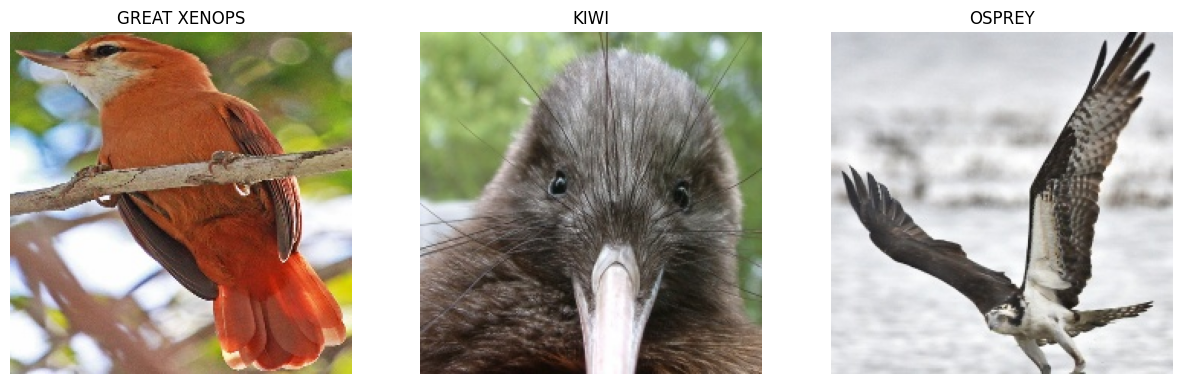

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 1
num_cols = 3

ds_idx = [13, 29, 43]
for plot_idx, idx in enumerate(ds_idx):
  ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
  ax.title.set_text(small_dataset.get_class(small_dataset.get_label(idx)))
  plt.axis('off')
  plt.imshow(small_dataset.get_image(idx))

### Loading images from a bundle

For large datasets, instead of loading images individually, we use an HDF5 bundle to efficiently load all data at once. This function utilizes `utils.load_data()` to load the data and includes an optional transform parameter for data preprocessing. The `utils.load_data()` function returns a tuple of a list of images, a list of labels, and a list of classes.

A `torchvision` Transform is applied to each image in `__getitem__` before returning.

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
  def __init__(self, transform=None):
    self.images = []
    self.labels = []
    self.classes = []
    self.transform = None

    self.images, self.labels, self.classes = utils.load_data()
    self.transform = transform

    assert len(self.images) == len(self.labels)

  def __len__(self):
    """Returns the number of examples in the dataset"""
    return len(self.images)

  def num_classes(self):
    """Returns the number of classes in the dataset"""
    return len(self.classes)

  def get_class(self, label):
    """Returns the name of the bird corresponding to the given label value"""
    return self.classes[label]

  def get_image(self, idx):
    """Returns the image of the idx'th example in the dataset"""
    return self.images[idx]

  def get_label(self, idx):
    """Returns the label of the idx'th example in the dataset"""
    return int(self.labels[idx])

  def __getitem__(self, idx):
    """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
    transformed_image = transform(self.get_image(idx))
    label = self.get_label(idx)
    return transformed_image.float(), label

  def display(self, idx):
    """Displays the image at a given index"""
    display(self.get_image(idx))

## Creating and visualizing the dataset

Create the `BirdDataset`. Pass in the transform as a parameter.We apply transformations to the dataset, converting images to tensors, and use a DataLoader to load the images in batches.

The first time you run this cell, it'll take about a minute to load the file.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

all_data = BirdDataset(transform)

### Visualizing the data

An important part of deep learning is to understand what type of data we're working with. Here, we'll visualize some of the examples of our training set.

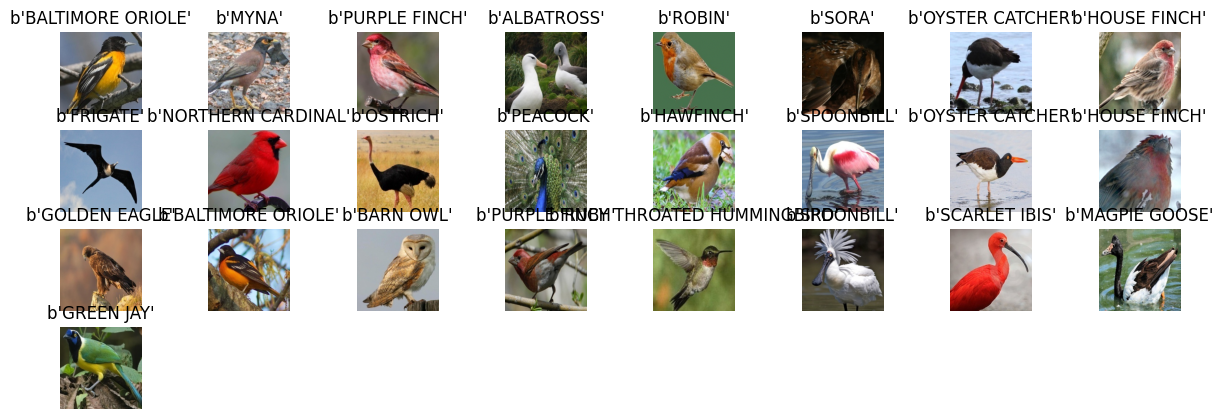

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for plot_idx in range(25):
  ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
  idx = (plot_idx * 373) % len(all_data)  # Gets a "random" index in the dataset

  # for this code, use `idx` as the dataset index
  cur_image = all_data.get_image(idx)
  cur_label = all_data.get_label(idx)
  cur_class = all_data.get_class(cur_label)

  ax.title.set_text(cur_class)
  plt.axis('off')
  plt.imshow(cur_image)

## Model structure

The BirdModel class defines a convolutional neural network with three convolutional blocks followed by fully connected layers. It uses batch normalization, ReLU activation, and dropout for regularization.

In [ ]:
class BirdModel(nn.Module):
    def __init__(self, num_classes=20):
        super(BirdModel, self).__init__()

        # First Convolution Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second Convolution Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Third Convolution Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.3)

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # First Convolution Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Second Convolution Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Third Convolution Block
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        # Global Average Pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the output

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Training setup

### Hyperparameters

Here's where we'll define our hyperparameters.

In [ ]:
batch_size = 32
learning_rate = 0.0005
num_epochs = 50
weight_decay_regularization = 0.01

In [ ]:
aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.6),
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.RandomAffine(degrees=20, shear=15),
    torchvision.transforms.RandomErasing(p=0.5),
    torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    torchvision.transforms.ToTensor(),

])

### Data Augmentation

Use various data augmentations to enhace training.

### Data loaders

Pass in the `batch_size` hyperparameter to the DataLoaders, and shuffle the training data loader.

In [ ]:
train_per = 0.7
val_per = 0.3

train_set, val_set = data.random_split(all_data, [train_per, val_per])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

## Training

It's time to train our model!

### Evaluation function

The evaluate function calculates the model's accuracy by comparing predictions to actual labels. It operates in evaluation mode, disabling gradient calculations for efficiency.



In [ ]:
def evaluate(model, data_loader, name="val"):
    correct = 0  # Number of correct predictions
    total = 0    # Total number of examples in the data loader

    # Ensure the model is in evaluation mode
    model.eval()

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for images, labels in data_loader:
            # Move data to the specified device (e.g., GPU or CPU)
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)

            # Get the predicted class (index of the max logit)
            _, predicted = torch.max(outputs, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print accuracy
    accuracy = 100 * correct / total

    return accuracy


### Training loop

The training loop feeds the data through the model, computes the loss, and performs backpropagation to update the weights. After each epoch, we evaluate the model on both the training and validation sets to track progress.

In [ ]:
train_accuracies = []
val_accuracies = []

model = BirdModel()
model.to(device=device)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#------------
# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
#----------

start_time = time.time()

for epoch in range(num_epochs):
    # Switch model to training mode
    model.train()
    correct_train = 0
    total_train = 0

    running_loss = 0.0
    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        pred_y = model(images)
        loss = criterion(pred_y, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(pred_y, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train

    # Validation Accuracy (using the evaluate function)
    val_accuracy = evaluate(model, val_loader, name="val")

    #------------
    # Update learning rate
    scheduler.step()  # Step the scheduler here
    #----------

    # add to lists
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print Epoch Stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

end_time = time.time()

print(f"Total training time: {end_time - start_time} sec")



Epoch [1/50], Loss: 2.6327, Training Accuracy: 22.11%, Validation Accuracy: 27.97%
Epoch [2/50], Loss: 2.2161, Training Accuracy: 32.02%, Validation Accuracy: 32.48%
Epoch [3/50], Loss: 2.0247, Training Accuracy: 36.33%, Validation Accuracy: 41.91%
Epoch [4/50], Loss: 1.8672, Training Accuracy: 41.61%, Validation Accuracy: 44.69%
Epoch [5/50], Loss: 1.7982, Training Accuracy: 43.35%, Validation Accuracy: 46.84%
Epoch [6/50], Loss: 1.7111, Training Accuracy: 46.83%, Validation Accuracy: 47.80%
Epoch [7/50], Loss: 1.5977, Training Accuracy: 49.50%, Validation Accuracy: 45.77%
Epoch [8/50], Loss: 1.5491, Training Accuracy: 50.83%, Validation Accuracy: 55.63%
Epoch [9/50], Loss: 1.4834, Training Accuracy: 54.08%, Validation Accuracy: 54.13%
Epoch [10/50], Loss: 1.4358, Training Accuracy: 55.96%, Validation Accuracy: 55.41%
Epoch [11/50], Loss: 1.3549, Training Accuracy: 58.53%, Validation Accuracy: 59.91%
Epoch [12/50], Loss: 1.2410, Training Accuracy: 62.89%, Validation Accuracy: 61.41%
E

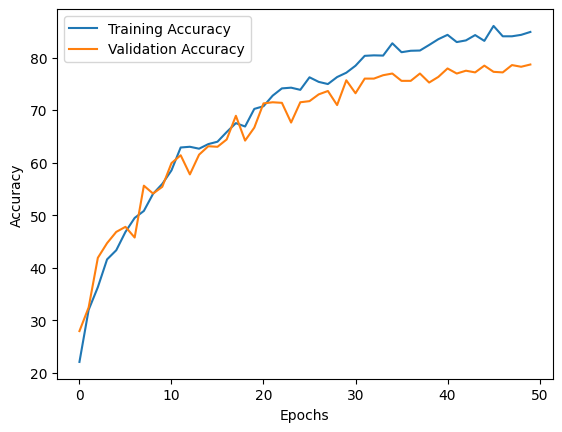

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Saving model weights

After training, the model's weights are saved with a filename that includes the date and model name, ensuring easy identification for future use.

In [ ]:
model_name = "LayerCNN"

date_str = date.today().strftime("%Y_%m_%d")
model_weights_filename = f"{date_str}_{model_name}.pt"

torch.save(model.state_dict(), f"{model_weights_filename}")
print(f"Model weights saved as {model_weights_filename}")

Model weights saved as 2024_12_02_LayerCNN.pt


## Predict functions

This function allows us to make predictions on new images after the model has been trained. It loads the image, processes it, and outputs the predicted class label.

In [ ]:
def load_model():
  model_path = '/content/drive/My Drive/2024_12_02_LayerCNN.pt'

  model = BirdModel()
  model.load_state_dict(torch.load(model_path))
  return model

In [ ]:
def predict(model, image_path):
  prediction = None
  ######## BEGIN YOUR CODE HERE ########

  model.eval()

  image = Image.open(image_path)
  image = transform(image)
  image = image.unsqueeze(0)

  # Disable gradient computation for evaluation
  with torch.no_grad():
    image, model = image.to(device), model.to(device)

    # Get model predictions
    output = model(image)

    # Get the predicted class (index of the max logit)
    _, prediction = torch.max(output, 1)

  ######### END YOUR CODE HERE #########
  return prediction.item()